# Ensambles - Boosting

En los modelos reales, siempre comenzamos con Ensambles.

__Boosting:__
* Es un meta-algoritmo de conjunto de aprendizaje automático para reducir principalmente el sesgo.
* Es una variación en el aprendizaje supervisado, y un grupo de algoritmos de aprendizaje automático que convierten al alumno débil en uno de cadena.
* Métodos de conjunto secuencial donde los alumnos base se generan secuencialmente.

El Boosting nunca cambia el predictor anterior y solo corrige el siguiente predictor aprendiendo de los errores. Dado que el impulso es codicioso, se recomienda establecer un criterio de detención como el rendimiento del modelo (early stopping) o varias etapas (por ejemplo, depth of tree in tree-based learners) para evitar el sobreajuste de los datos de entrenamiento.

Es mejor trabajar con modelos leves o débiles (x ej. separación con un línea vertical).

__Ejemplo:__ Adaboost (Adaptive Boosting), aumento de gradiente estocástico.

__Diferencia entre Boosting y Gradientboost:__
* La principal diferencia entre el boosting y el gradientboost es **cómo ambos algoritmos actualizan el modelo** a partir de predicciones incorrectas.
* En Gradientboost los errores se minimizan mediante un algoritmo de descenso de gradiente y producen un modelo en forma de modelos de predicción débiles, por ejemplo, árboles de decisión.
* El Gradientboost ajusta los pesos mediante el uso de gradiente (una dirección en la función de pérdida) utilizando un algoritmo llamado Gradient Descent, que optimiza iterativamente la pérdida del modelo actualizando los pesos. La pérdida normalmente significa la diferencia entre el valor pronosticado y el valor real.
* Para los algoritmos de regresión, usamos la pérdida MSE (Mean Squared Error) mientras que para los problemas de clasificación usamos la pérdida logarítmica.
* Los árboles existentes en el modelo permanecen intactos y, por lo tanto, ralentizan la tasa de sobreajuste. La producción del nuevo árbol se combina con la producción de los árboles existentes hasta que la pérdida se minimiza por debajo de un umbral o se alcanza un límite especificado de árboles.

### Carga de datos

Volvemos a cargas las librerías, importar el dataset y limpiarlo.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as metrics

from sklearn.model_selection import learning_curve

In [2]:
data = pd.read_csv('../Data/DS_Bitácora_27_Weather.csv')

# Columnas con muchos NaNs
columnas_descartables = ['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','RISK_MM','Date']
data = data.drop(columns=columnas_descartables) # Descarta las etiquetas especificadas de las filas o columnas.
data = data.dropna() # Descarta valores nulos

# Columnas con variables categoricas
columnas_descartables = ['WindGustDir','WindDir9am','WindDir3pm','RainToday']
data = data.drop(columns=columnas_descartables)

# Variables correlacionadas
data = data.drop(columns=['Temp3pm', 'Pressure9am'])

# Mapeo
data['RainTomorrow'] = data['RainTomorrow'].map({'Yes':1,'No':0})

print(data.shape)
data.head()

(112925, 11)


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Temp9am,RainTomorrow
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.1,16.9,0
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1007.8,17.2,0
2,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1008.7,21.0,0
3,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1012.8,18.1,0
4,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1006.0,17.8,0


## 1. AdaBoost

El objetivo de boosting es generar un modelo fuerte a partir de entrenar sucesivamente modelos débiles y combinar sus resultados. La idea es que cada modelo débil que agrego se enfoque en las instancias que fueron clasificadas erroneamente hasta el momento. Empecemos por decidir sobre que fetures del dataset vamos a trabajar (si trabajan sobre 2, luego podrán visualizar):

In [3]:
# Elegimos sobre que columnas queremos trabajar

columnas_entrenamiento = ['MaxTemp', 'Humidity3pm']
X = data[columnas_entrenamiento]
y = data['RainTomorrow']

# X = data[columnas_entrenamiento]
# y = data.RainTomorrow

# Separamos los datos en train y test (held-out) - Utilice un 30% del dataset como test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

Recordemos que este tipo de ensamble se enfoca en mejorar el sesgo de los modelos individuales a partir de los cuales está construido, por lo cual se suele usar modelos de alto sesgo y baja varianza.

1. Empiece por importar el clasificador AdaBoostClassifier y el modelo que usaremos como estimador debil, el DecisionTreeClassifier

In [4]:
from sklearn.ensemble import AdaBoostClassifier

2. Defina el modelo de manera que utilice 250 árboles de profundidad dos (2). Luego probaremos que sucede para mayores profundidades.

In [5]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),algorithm='SAMME', n_estimators=250)

# Entrenamos el modelo
ada_clf.fit(X_train,y_train)

# SAMME.R es para clasificación binaria y para predict.proba
# SAMME para todo, es decir clasificación multiclase

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

3. Calcule el error sobre el training set y sobre el test set. En base a estos resultados, ¿les parece que este ensamble está inclinado hacia el sesgo o hacia la varianza?

In [6]:
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)

print('Accuracy sobre el train set: ', metrics.accuracy_score(y_train, y_train_pred))
print('Accuracy sobre el test set: ', metrics.accuracy_score(y_test, y_test_pred))

Accuracy sobre el train set:  0.8300504762989108
Accuracy sobre el test set:  0.8324281244465435


4. Veamos ahora cómo es la distribución de los pesos de cada árbol. Para esto vamos a graficar el número del árbol vs el peso que el algoritmo le está dando para la clasificación final. Además, graficaremos también el accuracy de cada arbol sobre el training set.

Text(0.5, 0, 'Número de árbol')

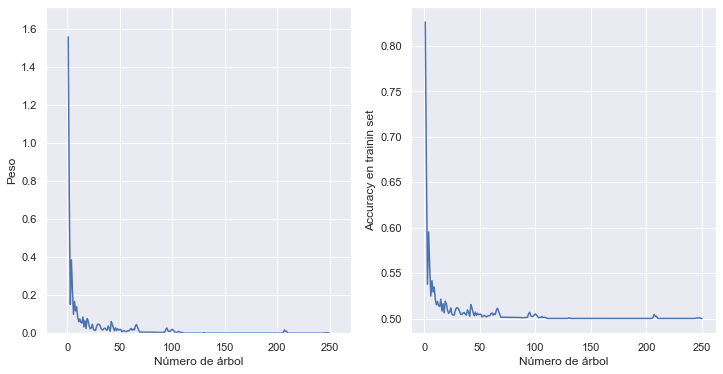

In [7]:
# Puede que el algoritmo termine antes de agregar todos los arboles
# Tomamos entonces la cantidad de arboles que realmente tiene el ensamble
numero_arboles = len(ada_clf)

# En la variable 'estimator_weights_' esta el peso de cada arbol
pesos = ada_clf.estimator_weights_[:numero_arboles]

# Calculamos el accuracy DE CADA ARBOL en el ensamble. En 'estimator_errors_' esta el error que comete cada uno.
errores_arboles = ada_clf.estimator_errors_[:numero_arboles]

# ¡Cómo puede calcular el accuracy de cada arbol a partir de saber el error que comete cada uno?
accuracy_arboles = 1 - errores_arboles

# Graficamos
plt.figure(figsize = (12,6))
plt.subplot(121)

# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' los pesos
plt.plot(range(1, numero_arboles + 1), pesos)
plt.ylabel('Peso')
plt.xlabel('Número de árbol')
plt.ylim((0, pesos.max() * 1.1))
plt.xlim((-20, numero_arboles + 20))
plt.subplot(122)

# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' el accuracy de cada arbol
plt.plot(range(1, numero_arboles + 1), accuracy_arboles)
plt.ylabel('Accuracy en trainin set')
plt.xlabel('Número de árbol')

5. ¿Le parece relevante la contribución de todos los árboles?¿Cómo se relaciona el accuracy de cada árbol con el peso que le damos en la clasificación final?

* Éste es un caso en el que tenemos bajo sesgo desde un principio.
* Con pocos números de árboles, el modelo nos genera un buen performance, un buen desempeño, un buen accuracy.
* Pero, a pesar de que con modelos más grandes el accuracy es más bajo, al sumar el promedio ponderado del error que cometen todos los árboles, aportan a la reducción del error final.
* La decisión de cuántos estimados utilizar, es decir, de cuántos modelos utilizar, depende del problema en particular, viendo si se justifica o no aumentar el tiempo y gasto del estudio en más modelos o no, dependiendo de cuánto va variando el accuracy.
* Para aquellos modelos en los que de un principio tengamos alto sesgo y alta varianza, el aporte de cada nuevo árbol va a ser altísimo.

6. Veamos cómo cambia el error en el training set y en el test set a medida que agregamos árboles. Para esto vamos a utilizar un metodo llamado `staged_predict`, que nos devuelve la predicción del ensamble en cada instancia en que fuimos agregandole un nuevo estimador.

Text(0.5, 0, 'Número de árboles')

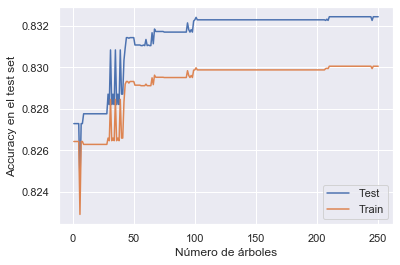

In [8]:
# Definimos listas vacias donde vamos a "appendear" (agregar) los valores
accuracy_test = []
accuracy_train = []

# Calculamos el accuracy sobre el test set
for prediccion_test in ada_clf.staged_predict(X_test):
    accuracy_test.append(metrics.accuracy_score(prediccion_test, y_test))
    # accuracy_test.append(metrics.accuracy_score(y_test, y_test_pred))
    
# Calculamos el accuracy sobre el training set    
for prediccion_train in ada_clf.staged_predict(X_train):  
    accuracy_train.append(metrics.accuracy_score(prediccion_train, y_train))
    #accuracy_train.append(metrics.accuracy_score(y_train, y_train_pred))
    
plt.plot(range(1, len(accuracy_test) + 1), accuracy_test, label = 'Test')
plt.plot(range(1, len(accuracy_test) + 1), accuracy_train, label = 'Train')
plt.legend()
plt.ylabel('Accuracy en el test set')
plt.xlabel('Número de árboles')

7. Grafiquemos la frontera de decisión del clasificador

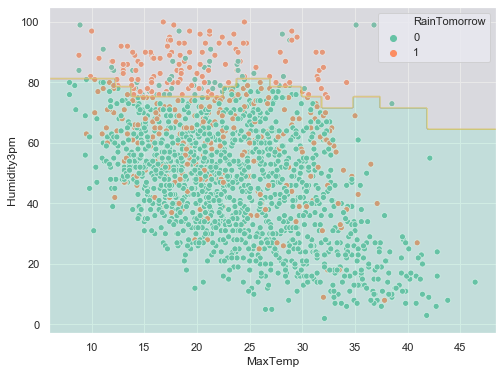

In [9]:
N = 20 #para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (8,6))

ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = ada_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

plt.show()

8. Repita lo realizado hasta ahora pero utilice árboles de profundidad diez. Preste atención a las curvas de accuracy en train y test y al gráfico de la frontera. ¿Qué le parece que esta sucediendo en este caso?

In [10]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),algorithm='SAMME', n_estimators=250)

# Entrenamos el modelo
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                           

In [11]:
y_train_pred = ada_clf.predict(X_train)
y_test_pred = ada_clf.predict(X_test)

print('Accuracy sobre el train set: ', metrics.accuracy_score(y_train, y_train_pred))
print('Accuracy sobre el test set: ', metrics.accuracy_score(y_test, y_test_pred))

Accuracy sobre el train set:  0.8477488076713854
Accuracy sobre el test set:  0.8228348780919771


Text(0.5, 0, 'Número de árbol')

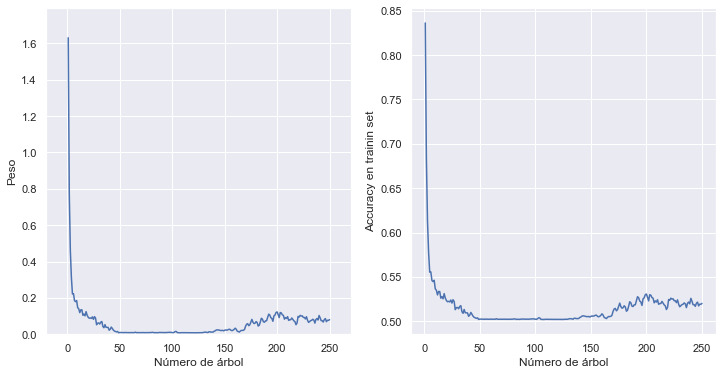

In [12]:
numero_arboles = len(ada_clf)

# En la variable 'estimator_weights_' esta el peso de cada arbol
pesos = ada_clf.estimator_weights_[:numero_arboles]

# Calculamos el accuracy DE CADA ARBOL en el ensamble. En 'estimator_errors_' esta el error que comete cada uno.
errores_arboles = ada_clf.estimator_errors_[:numero_arboles]

# ¡Cómo puede calcular el accuracy de cada arbol a partir de saber el error que comete cada uno?
accuracy_arboles = 1 - errores_arboles

# Graficamos
plt.figure(figsize = (12,6))
plt.subplot(121)

# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' los pesos
plt.plot(range(1, numero_arboles + 1), pesos)
plt.ylabel('Peso')
plt.xlabel('Número de árbol')
plt.ylim((0, pesos.max() * 1.1))
plt.xlim((-20, numero_arboles + 20))
plt.subplot(122)

# En el eje 'x' ponemos el índice (número) de cada arbol, en el 'y' el accuracy de cada arbol
plt.plot(range(1, numero_arboles + 1), accuracy_arboles)
plt.ylabel('Accuracy en trainin set')
plt.xlabel('Número de árbol')

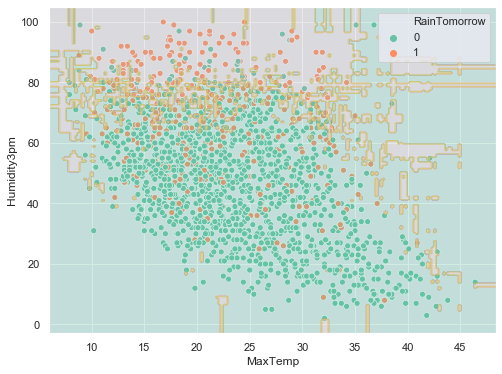

In [13]:
N = 20 #Para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (8,6))

ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = ada_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

plt.show()

* Con una profundidad mayor, sobreajusta, porque si bien es mayor el accuracy del train, el del test es menor.

### 2. XGBoost

__XGBoost__ o **eXtreme Gradient Boosting**, es un modelo de gradient boosting sumamente optimizado, y tiene muy buen desempeño, tanto sobre los datos como desde el punto de vista computacional. Como todos los modelos basados en árboles, sirve tanto para regresión como clasificación.

XGBoost __no viene incluido en Scikit-Learn__, pero es muy fácil de instalar y se utiliza exactamente igual a un modelo de Scikit-Learn. Validación cruzada, optimización de hiperparámetros y métricas de evaluación ya vienen incorporados, convirtiéndolo en un modelo sumamente completo.

__2.1__ Instalar y entrenar un modelo con `XGBoost` sobre este dataset. Explorar diferencias y similitudes con `Adaboost`. 

In [14]:
import xgboost as xgb

In [15]:
# Separamos los datos en train y test (held-out)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)
# Es una buena estrategia utilizar 'stratify' para datos desbalanceados.
# No cambiar el objetivo 'target'.


# XGB Classifier
xgb_cl = xgb.XGBClassifier(n_estimators=250, max_depht= 2)
# Lo entreno con los 250 árboles del ejemplo anterior
# Seed, para indicar en qué punto comienzan los cortes
# Siempre poner profundidad


# Fit the classifier to the training set
xgb_cl.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric=['error'])
# eval_metric=['error'] es RMSE

[21:31:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { max_depht } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.16870	validation_1-error:0.16757
[1]	validation_0-error:0.16870	validation_1-error:0.16748
[2]	validation_0-error:0.16863	validation_1-error:0.16793
[3]	validation_0-error:0.16819	validation_1-error:0.16798
[4]	validation_0-error:0.16813	validation_1-error:0.16819
[5]	validation_0-error:0.16818	validation_1-error:0.16804
[6]	validation_0-error:0.16844	validation_1-error:0.16787
[7]	validation_0-error:0.16808	validation_1-error:0.16742
[8]	validation_0-error:0.16792	validation_1-error:0.16781
[9]	validation_0-error:0.16801	validation_1-error:0.16796
[10]	validation_0-error:0.16792	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depht=2,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
# Predict the labels of the test set (cjto. prueba): preds
y_train_pred = xgb_cl.predict(X_train)
y_test_pred = xgb_cl.predict(X_test)

In [17]:
# Compute the accuracy: accuracy
accuracy_train = metrics.accuracy_score(y_train, y_train_pred)
accuracy_test = metrics.accuracy_score(y_test, y_test_pred)

print('Accuracy sobre el train set: ', metrics.accuracy_score(y_train, y_train_pred)) # Accuracy Asociado al Train
print('Accuracy sobre el test set: ', metrics.accuracy_score(y_test, y_test_pred)) # Accuracy Asociado al Test

Accuracy sobre el train set:  0.8379065619188584
Accuracy sobre el test set:  0.8296829801050829


In [18]:
evals_results = xgb_cl.evals_result()
evals_results = xgb_cl.evals_result()

# Validation Resource 0 es para el train, es decir, la Evaluación que generó p/ dicho conjunto (para todos los árboles)
# Validation Resource 0 es para el test

In [19]:
print(evals_results['validation_0']['error'][250-1]) # Error Train
print(1-evals_results['validation_0']['error'][250-1]) # Accuracy Train
print(evals_results['validation_1']['error'][250-1]) # Error Test
print(1-evals_results['validation_1']['error'][250-1]) # Accuracy Test

# Va utilizando los errores anteriores para ir aprendiendo y mejorando
# El valor de train para último árbol (250), es el acurracy para toda la muestra (contrastamos con Adaboost) 

0.162093
0.837907
0.170317
0.829683


In [20]:
print(xgb_cl.feature_importances_)

# Indica cuál es el atributo mas importante, el que mejor separa los datos

[0.0889418 0.9110582]


In [21]:
# Definimos listas vacias donde vamos a "appendear" (agregar) los valores
accuracy_test = []
accuracy_train = []

# Calculamos el accuracy sobre el training set    
for prediccion_train in evals_results['validation_0']['error']:
    accuracy_train.append(1-prediccion_train)
    
# Calculamos el accuracy sobre el test set
for prediccion_test in evals_results['validation_1']['error']:
    accuracy_test.append(1-prediccion_test)
    
# Voy agregando a la lista el error de la predicción, del 1- 1er árbol, 1- 2do árbol, etc., para train y para test

Text(0.5, 0, 'Número de árboles')

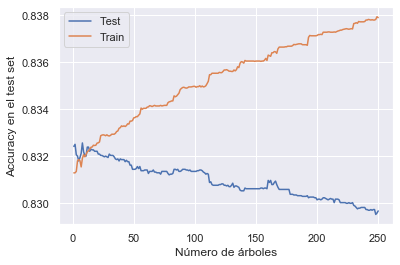

In [22]:
fig, ax = plt.subplots()
plt.plot(range(1, len(accuracy_test) + 1), accuracy_test, label = 'Test')
plt.plot(range(1, len(accuracy_test) + 1), accuracy_train, label = 'Train')

plt.legend()
plt.ylabel('Accuracy en el test set')
plt.xlabel('Número de árboles')

# Muestra cómo se comporto el accuracy con train y test
# Dsd 50 funciona bien
# Con 150 arboles podría ser bueno sin sobreajustar
# Los graficos de error y accuracy deberían ser opuestos.

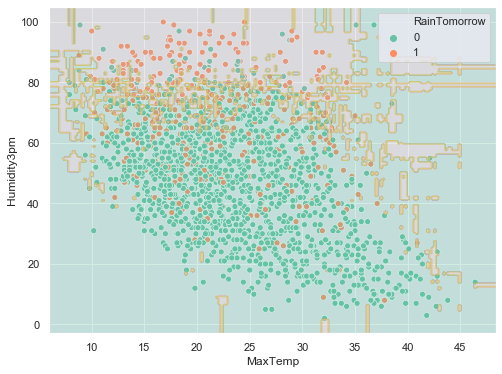

In [23]:
N = 20 # Para no graficar todos los puntos y saturar el grafico

plt.figure(figsize = (8,6))

ax = sns.scatterplot(X_test[::N].MaxTemp, X_test[::N].Humidity3pm, hue=y_test[::N], palette='Set2')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                      np.linspace(*ylim, num=200))
Z = ada_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
contours = ax.contourf(xx, yy, Z, alpha=0.3, cmap = 'Set2')

plt.show()